1.1 Loading EEG Features (CLISA-MSCL)
CLISA and MSCL use differential entropy (DE) features for EEG encoding, as established in:

Shen et al., 2023 (CLISA) [1]: EEG feature alignment through contrastive learning.
Deng et al., 2024 (MSCL) [2]: Multi-source contrastive learning for cross-subject EEG alignment.

In [46]:
import numpy as np
import os

# Define emotion categories
emotion_classes = ["Excited_Happy", "Calm_Content", "Sad_Bored", "Angry_Fearful"]

# Load EEG features
eeg_features = {}
eeg_dir = "output_eeg_features_based_on_emotion"

for emotion in emotion_classes:
    eeg_features[emotion] = np.load(os.path.join(eeg_dir, f"{emotion}.npy"))

# Verify loaded data
for emotion, data in eeg_features.items():
    print(f"{emotion}: {data.shape}")  # Expected shape: (trials, 40) per emotion


Excited_Happy: (220, 40)
Calm_Content: (220, 40)
Sad_Bored: (220, 40)
Angry_Fearful: (220, 40)


1.2 Loading Facial Features (ViT)
For facial features, we use Vision Transformers (ViT), following:

Dosovitskiy et al., 2020 (ViT) [3]: Transformer-based vision models outperform CNNs in feature extraction.
Milmer, 2025 [4]: ViT combined with Multiple Instance Learning (MIL) improves emotion recognition.

In [47]:
# Load Facial Features
face_features = {}

face_dir = r"C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\FYP_2\Aheed\Pytorch_Retinaface-master\output_facial_features"

for emotion in emotion_classes:
    face_features[emotion] = np.load(os.path.join(face_dir, f"{emotion}_features.npy"), allow_pickle=True)

# Verify loaded data
for emotion, data in face_features.items():
    print(f"{emotion}: {data.shape}")  # Expected shape: (trials, feature_dim)


Excited_Happy: (22000, 768)
Calm_Content: (21999, 768)
Sad_Bored: (22000, 768)
Angry_Fearful: (21400, 768)


Step 2: Aligning EEG and Facial Data
Since EEG and facial features were extracted separately, we must ensure they align trial-by-trial. We assume an equal number of trials per emotion class.

MSCL (Deng et al., 2024) [2] suggests domain adaptation for feature alignment.
Hyper-MML (2025) [5] suggests hypergraph learning to handle complex relations.

In [48]:
# Ensure equal trials in EEG and Facial Features
min_trials = min(min(len(eeg_features[e]), len(face_features[e])) for e in emotion_classes)

# Trim datasets to match
for emotion in emotion_classes:
    eeg_features[emotion] = eeg_features[emotion][:min_trials]
    face_features[emotion] = face_features[emotion][:min_trials]

# Verify final shapes
for emotion in emotion_classes:
    print(f"{emotion}: EEG {eeg_features[emotion].shape}, Face {face_features[emotion].shape}")


Excited_Happy: EEG (220, 40), Face (220, 768)
Calm_Content: EEG (220, 40), Face (220, 768)
Sad_Bored: EEG (220, 40), Face (220, 768)
Angry_Fearful: EEG (220, 40), Face (220, 768)


2.1 Normalizing EEG & Facial Features
Normalization is critical to ensure stable training and prevent bias due to differing feature scales.

📌 Citations & Justification

Shen et al., 2023 (CLISA) [1]: EEG signals benefit from z-score normalization.
Deng et al., 2024 (MSCL) [2]: Feature standardization improves contrastive learning.
Dosovitskiy et al., 2020 (ViT) [3]: Standardizing vision embeddings stabilizes transformer training.
🔹 Normalization Strategy

EEG features: Z-score normalization (mean=0, std=1) per feature dimension.
Facial features: Min-max scaling ([0,1] range) for stable ViT embeddings.

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize EEG Features (Z-score)
eeg_scaler = StandardScaler()
for emotion in emotion_classes:
    eeg_features[emotion] = eeg_scaler.fit_transform(eeg_features[emotion])

# Normalize Facial Features (Min-Max Scaling)
face_scaler = MinMaxScaler()
for emotion in emotion_classes:
    face_features[emotion] = face_scaler.fit_transform(face_features[emotion])

# Verify normalization
for emotion in emotion_classes:
    print(f"{emotion}: EEG mean {eeg_features[emotion].mean(axis=0).round(4)}, std {eeg_features[emotion].std(axis=0).round(4)}")
    print(f"{emotion}: Facial min {face_features[emotion].min():.4f}, max {face_features[emotion].max():.4f}")


Excited_Happy: EEG mean [ 0.  0.  0. -0.  0. -0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.
 -0. -0.  0.  0. -0.  0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0.
 -0.  0. -0. -0.], std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Excited_Happy: Facial min 0.0000, max 1.0000
Calm_Content: EEG mean [-0.  0. -0.  0.  0.  0. -0.  0.  0. -0.  0. -0. -0. -0.  0.  0. -0.  0.
  0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0.
  0.  0. -0. -0.], std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Calm_Content: Facial min 0.0000, max 1.0000
Sad_Bored: EEG mean [ 0.  0. -0.  0.  0. -0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0. -0.  0.
 -0.  0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0.  0. -0.
  0.  0. -0.  0.], std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

2.2 EEG Augmentation for CLISA & MSCL
Since CLISA and MSCL require contrastive learning, we apply EEG augmentations to create diverse views.

📌 Citations & Justification

CLISA (Shen et al., 2023) [1]: EEG contrastive learning improves feature generalization.
MSCL (Deng et al., 2024) [2]: Multi-source contrastive learning enhances domain adaptation.
Luo et al., 2021 [6]: EEG augmentation techniques boost model robustness.
🔹 Augmentation Strategy

Gaussian Noise (N(0, 0.05)) - Introduces small variations to prevent overfitting.
Time Warping (Random stretching/shrinking) - Simulates EEG time shifts.
Frequency Masking (Randomly masking some features) - Regularization for robustness

In [50]:
import numpy as np

def augment_eeg(eeg_batch, noise_std=0.05):
    """
    Apply EEG augmentations: Gaussian noise, time warping, and frequency masking.
    """
    # Apply Gaussian Noise
    noisy_eeg = eeg_batch + np.random.normal(0, noise_std, eeg_batch.shape)

    # Apply Time Warping (Random Stretching/Shrinking)
    factor = np.random.uniform(0.9, 1.1, (eeg_batch.shape[0], 1))
    warped_eeg = eeg_batch * factor

    # Apply Frequency Masking (Randomly mask some features)
    mask = np.random.rand(*eeg_batch.shape) > 0.9  # 10% masking probability
    masked_eeg = np.where(mask, 0, eeg_batch)

    return noisy_eeg, warped_eeg, masked_eeg


2.3 Facial Feature Augmentation (ViT)
Since facial data comes from ViT embeddings, we apply slight perturbations to enhance contrastive learning.

📌 Citations & Justification

ViT (Dosovitskiy et al., 2020) [3]: Slight perturbations improve contrastive loss optimization.
Chen et al., 2020 (SimCLR) [7]: Feature perturbation increases contrastive learning effectiveness.
🔹 Augmentation Strategy

Gaussian Noise (N(0, 0.01)) - Small noise in feature space.
Feature Dropout (p=0.1) - Randomly drop 10% of features for robustness.

In [51]:
def augment_face(face_batch, noise_std=0.01, dropout_p=0.1):
    """
    Apply facial feature augmentations: Gaussian noise and feature dropout.
    """
    # Apply Gaussian Noise
    noisy_face = face_batch + np.random.normal(0, noise_std, face_batch.shape)

    # Apply Feature Dropout
    dropout_mask = np.random.rand(*face_batch.shape) > dropout_p
    dropped_face = np.where(dropout_mask, face_batch, 0)

    return noisy_face, dropped_face


✅ Step 2: Creating Data Loaders
We need PyTorch DataLoaders to efficiently batch and shuffle EEG and facial features for training.

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

# Define emotion classes
emotion_classes = ["Excited_Happy", "Calm_Content", "Sad_Bored", "Angry_Fearful"]
emotion_to_label = {e: i for i, e in enumerate(emotion_classes)}  # Encode labels

class EEGFaceDataset(Dataset):
    def __init__(self, eeg_dir, face_dir):
        self.eeg_features = []
        self.face_features = []
        self.labels = []

        for emotion in emotion_classes:
            eeg_data = np.load(os.path.join(eeg_dir, f"{emotion}.npy"))  # Shape (220, 40)
            face_data = np.load(os.path.join(face_dir, f"{emotion}_features.npy"))  # (220, feature_dim)
            
            min_trials = min(len(eeg_data), len(face_data))  # Ensure matching trials
            
            self.eeg_features.append(eeg_data[:min_trials])
            self.face_features.append(face_data[:min_trials])
            self.labels.extend([emotion_to_label[emotion]] * min_trials)

        # Convert to tensors
        self.eeg_features = torch.tensor(np.vstack(self.eeg_features), dtype=torch.float32)
        self.face_features = torch.tensor(np.vstack(self.face_features), dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.eeg_features[idx], self.face_features[idx], self.labels[idx]

# Define paths
eeg_dir = "output_eeg_features_based_on_emotion"
face_dir = r"C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\FYP_2\Aheed\Pytorch_Retinaface-master\output_facial_features"

# Create dataset
dataset = EEGFaceDataset(eeg_dir, face_dir)

# Split into train (80%), val (10%), test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Check a batch
sample_eeg, sample_face, sample_labels = next(iter(train_loader))
print(f"EEG batch shape: {sample_eeg.shape}")  # Expected: (batch, 40)
print(f"Facial batch shape: {sample_face.shape}")  # Expected: (batch, feature_dim)
print(f"Labels: {sample_labels[:5]}")  # Example output: tensor([0, 2, 1, 3, 0])


EEG batch shape: torch.Size([32, 40])
Facial batch shape: torch.Size([32, 768])
Labels: tensor([0, 2, 0, 1, 2])


✅ Step 3: Contrastive Learning Loss (CLISA & MSCL)
We need to:

CLISA (Contrastive Learning for EEG) → Align EEG representations.
MSCL (Multi-Source Contrastive Learning) → Improve cross-modal alignment (EEG & Face).
🛠 What We Will Do in This Step?
Project EEG & Facial Features → Pass them through a shared encoder.
Contrastive Loss Function → Using NT-Xent (Normalized Temperature-scaled Cross-Entropy Loss) for contrastive learning.
Batch-wise Similarity Computation → Ensuring correct matching.

In [53]:
import torch
import torch.nn.functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

    def forward(self, eeg_embeds, face_embeds, labels):
        """
        eeg_embeds: (batch_size, embed_dim)
        face_embeds: (batch_size, embed_dim)
        labels: (batch_size)
        """
        batch_size = eeg_embeds.shape[0]

        # Normalize embeddings
        eeg_embeds = F.normalize(eeg_embeds, p=2, dim=-1)
        face_embeds = F.normalize(face_embeds, p=2, dim=-1)

        # Compute similarity matrix
        sim_matrix = self.cosine_similarity(eeg_embeds.unsqueeze(1), face_embeds.unsqueeze(0))  # (B, B)
        
        # Get similarity of positive pairs (same label)
        labels_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)  # (B, B)

        # Mask to exclude diagonal (self-similarity)
        labels_matrix.fill_diagonal_(False)

        # Extract positive and negative similarities
        pos_sim = sim_matrix[labels_matrix]  # All positive pairs
        neg_sim = sim_matrix[~labels_matrix]  # All negative pairs

        # Avoid empty tensors (edge case where no positive pairs exist)
        if pos_sim.numel() == 0:
            return torch.tensor(0.0, device=eeg_embeds.device)

        # Compute NT-Xent loss
        logits = torch.cat([pos_sim, neg_sim], dim=0).unsqueeze(0) / self.temperature
        targets = torch.zeros(logits.shape[0], dtype=torch.long, device=eeg_embeds.device)

        loss = F.cross_entropy(logits, targets)
        return loss

# Test loss function
loss_fn = ContrastiveLoss(temperature=0.5)

# Generate random embeddings for testing
eeg_embed_test = torch.randn(32, 128)  # Simulated EEG embeddings
face_embed_test = torch.randn(32, 128)  # Simulated Face embeddings
labels_test = torch.randint(0, 4, (32,))  # Random labels

loss_value = loss_fn(eeg_embed_test, face_embed_test, labels_test)
print(f"Contrastive Loss: {loss_value.item()}")


Contrastive Loss: 6.877778053283691


3.1 Create PyTorch Dataset Class
We need a custom dataset class that loads EEG and facial features, applies augmentations, and returns paired samples for contrastive learning.

📌 Citations & Justification

CLISA (Shen et al., 2023) [1]: Requires contrastive pairs of EEG signals for alignment.

MSCL (Deng et al., 2024) [2]: Multi-source learning requires EEG-Facial alignment.

SimCLR (Chen et al., 2020) [3]: Contrastive learning benefits from augmented views of the same sample.

🔹 Dataset Structure

EEG Feature Pairs: (original EEG, augmented EEG)

Facial Feature Pairs: (original face, augmented face)

Fusion Samples: (EEG, face) for multimodal learning

In [54]:
import torch
import numpy as np
from torch.utils.data import Dataset

class EEGFacialDataset(Dataset):
    def __init__(self, eeg_data, face_data, augment=True):
        """
        eeg_data: Dict of EEG features per emotion
        face_data: Dict of facial features per emotion
        augment: Apply augmentations or not
        """
        self.eeg_data = []
        self.face_data = []
        self.labels = []
        self.augment = augment

        # Flatten dictionary structure into lists
        for label, eeg_trials in eeg_data.items():
            face_trials = face_data[label]

            for eeg_sample, face_sample in zip(eeg_trials, face_trials):
                self.eeg_data.append(eeg_sample)
                self.face_data.append(face_sample)
                self.labels.append(label)

        # Convert to numpy arrays for fast indexing
        self.eeg_data = np.array(self.eeg_data, dtype=np.float32)
        self.face_data = np.array(self.face_data, dtype=np.float32)

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx]  # ✅ Corrected Variable Name
        face = self.face_data[idx]  # ✅ Corrected Variable Name

        print(f"EEG Sample at {idx}: {type(eeg)} - {eeg.shape}")
        print(f"Face Sample at {idx}: {type(face)} - {face.shape}")

        # Convert to torch tensors (ensure correct dtype)
        eeg = torch.tensor(eeg, dtype=torch.float32)
        face = torch.tensor(face, dtype=torch.float32)

        return {"eeg1": eeg, "face1": face}  # ✅ Now returns a dictionary


3.2 Create DataLoaders
Now, we convert our dataset into PyTorch DataLoaders for batch processing.

In [55]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

try:
    # Unpack the batch directly as tuple
    eeg_batch, face_batch, labels = next(iter(train_loader))
    print(f"✅ EEG Batch Shape: {eeg_batch.shape}")
    print(f"✅ Face Batch Shape: {face_batch.shape}")
    print(f"✅ Labels Shape: {labels.shape}")
except Exception as e:
    print(f"❌ DataLoader Failed: {e}")

# Check first sample format
first_sample = dataset[0]
print(f"First sample format: {[tensor.shape for tensor in first_sample]}")

✅ EEG Batch Shape: torch.Size([32, 40])
✅ Face Batch Shape: torch.Size([32, 768])
✅ Labels Shape: torch.Size([32])
First sample format: [torch.Size([40]), torch.Size([768]), torch.Size([])]


In [56]:
import time
start_time = time.time()

print("Creating DataLoader...")
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
print(f"DataLoader creation took {time.time() - start_time:.2f} seconds")

print("\nLoading first batch...")
batch_start = time.time()
try:
    eeg_batch, face_batch, labels = next(iter(train_loader))
    print(f"✅ Batch load took {time.time() - batch_start:.2f} seconds")
    print(f"✅ EEG Batch Shape: {eeg_batch.shape}")
    print(f"✅ Face Batch Shape: {face_batch.shape}")
    print(f"✅ Labels Shape: {labels.shape}")
except Exception as e:
    print(f"❌ DataLoader Failed: {e}")

Creating DataLoader...
DataLoader creation took 0.00 seconds

Loading first batch...
✅ Batch load took 0.00 seconds
✅ EEG Batch Shape: torch.Size([32, 40])
✅ Face Batch Shape: torch.Size([32, 768])
✅ Labels Shape: torch.Size([32])


🛠️ Step 2: Multi-Source Contrastive Loss
🔹 Pulls same-emotion EEG features together while pushing different emotions apart.
🔹 Similar to SupCon Loss (Khosla et al., 2020) [4].

In [57]:
import torch.nn.functional as F

def multi_source_contrastive_loss(anchor, positive, negatives, margin=1.0):
    """
    Compute contrastive loss for multi-source adaptation.
    Args:
        anchor: EEG embedding from source domain.
        positive: Same emotion EEG embedding from another subject.
        negatives: Different emotion embeddings from other subjects.
        margin: Margin for negative pairs.
    Returns:
        Scalar contrastive loss.
    """
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = torch.stack([F.pairwise_distance(anchor, neg) for neg in negatives]).mean()

    loss = pos_dist.mean() - neg_dist.mean() + margin
    return torch.clamp(loss, min=0)  # Ensures non-negative loss


🛠️ Step 3: Training Function for MSCL
🔹 Optimizes embeddings using MMD + Multi-Source Contrastive Loss.
🔹 Uses early stopping and adaptive learning rates.

In [58]:
import torch.nn as nn

class MMDLoss(nn.Module):
    def __init__(self, kernel_mul=2.0, num_kernels=5):
        super().__init__()
        self.kernel_mul = kernel_mul
        self.num_kernels = num_kernels

    def gaussian_kernel(self, source, target):
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0)
        total1 = total.unsqueeze(1)
        L2_distance = ((total0 - total1) ** 2).sum(2)
        bandwidth = torch.mean(L2_distance).detach()
        bandwidth_list = [bandwidth * (self.kernel_mul ** i) for i in range(self.num_kernels)]
        kernel_val = None
        
        for bandwidth in bandwidth_list:
            kernel = torch.exp(-L2_distance / (2 * bandwidth + 1e-5))
            kernel_val = kernel if kernel_val is None else kernel_val + kernel
            
        return kernel_val

    def forward(self, source, target):
        batch_size = source.size(0)
        kernels = self.gaussian_kernel(source, target)
        
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        
        loss = torch.mean(XX + YY - XY - YX)
        return loss

# Initialize MMD loss
mmd_loss = MMDLoss()

def train_mscl(eeg_data, model, optimizer, epochs=100, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        for source_batch, target_batch in eeg_data:
            optimizer.zero_grad()
            
            source_features = model(source_batch)
            target_features = model(target_batch)

            # Compute losses
            loss_mmd = mmd_loss(source_features, target_features)
            loss_contrastive = multi_source_contrastive_loss(
                anchor=source_features,
                positive=target_features,
                negatives=[model(neg) for neg in eeg_data if neg is not target_batch]
            )

            loss = loss_mmd + loss_contrastive
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(eeg_data)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0  
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


🔹 Self-Attention captures complex interdependencies between EEG and facial features.
🔹 Cross-Attention ensures both modalities contribute effectively to emotion recognition.
🔹 State-of-the-art approaches (Milmer, 2025 [1] & HyperMML, 2024 [2]) show transformers outperform traditional fusion models.

🛠️ Step 1: Transformer-Based Fusion Model
We implement a dual-stream transformer:

EEG encoder: Learns temporal dependencies in EEG signals.
Facial encoder: Extracts deep feature representations.
Cross-Attention Fusion Layer: Merges EEG and facial embeddings.

In [ ]:
import pandas as pd
import numpy as np
import time
import copy
import torch
import torch.nn as nn

class EEGFaceTransformer(nn.Module):
    def __init__(self, eeg_dim=40, face_dim=768, hidden_dim=256):
        super().__init__()
        self.eeg_proj = nn.Linear(eeg_dim, hidden_dim)
        self.face_proj = nn.Linear(face_dim, hidden_dim)
        
        # Encoders
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads,
            dim_feedforward=hidden_dim*2,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, eeg, face):
        # Print input shapes for debugging
        print(f"Input EEG shape: {eeg.shape}")
        print(f"Input Face shape: {face.shape}")
        
        # Project to same dimension
        eeg = self.eeg_proj(eeg)  # Shape: [batch_size, hidden_dim]
        face = self.face_proj(face)  # Shape: [batch_size, hidden_dim]
        
        print(f"After projection - EEG shape: {eeg.shape}")
        print(f"After projection - Face shape: {face.shape}")
        
        # Add sequence dimension
        eeg = eeg.unsqueeze(1)  # Shape: [batch_size, 1, hidden_dim]
        face = face.unsqueeze(1)  # Shape: [batch_size, 1, hidden_dim]
        
        # Encode
        eeg_enc = self.encoder(eeg).squeeze(1)  # Shape: [batch_size, hidden_dim]
        face_enc = self.encoder(face).squeeze(1)  # Shape: [batch_size, hidden_dim]
        
        # Concatenate and classify
        fusion = torch.cat([eeg_enc, face_enc], dim=1)  # Shape: [batch_size, hidden_dim*2]
        return self.classifier(fusion)  # Shape: [batch_size, num_classes]

def train_model(model, train_loader, val_loader, num_epochs=150, patience=30):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    # Create checkpoints directory if it doesn't exist
    import os
    os.makedirs('checkpoints', exist_ok=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (eeg, face, labels) in enumerate(train_loader):
            batch_start_time = time.time()
            
            eeg, face, labels = eeg.to(device), face.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(eeg, face)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}, "
                      f"Time: {time.time() - batch_start_time:.3f}s, "
                      f"Loss: {loss.item():.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for eeg, face, labels in val_loader:
                eeg, face, labels = eeg.to(device), face.to(device), labels.to(device)
                outputs = model(eeg, face)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        train_acc = 100. * train_correct / train_total
        
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss/len(train_loader):.3f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            # Save checkpoint
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'train_acc': train_acc
            }
            torch.save(checkpoint, 'checkpoints/best_model.pt')
            print(f'Saved new best model with validation loss: {val_loss:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break
    
    # Load best model
    model.load_state_dict(best_model)
    return model

# To load the best model later, you can use:
def load_best_model(model):
    checkpoint = torch.load('checkpoints/best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint

# Before training, verify data loaders
print("Sample from train_loader:")
eeg, face, labels = next(iter(train_loader))
print(f"EEG shape: {eeg.shape}")
print(f"Face shape: {face.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels in batch: {torch.unique(labels).tolist()}")

# Train the model
model = EEGFaceTransformer(eeg_dim=40, face_dim=768)
train_model(model, train_loader, val_loader)

Sample from train_loader:
EEG shape: torch.Size([32, 40])
Face shape: torch.Size([32, 768])
Labels shape: torch.Size([32])
Unique labels in batch: [0, 1, 2, 3]
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Batch 0/28, Time: 0.012s, Loss: 1.3948
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([3

EEGFaceTransformer(
  (eeg_proj): Linear(in_features=40, out_features=256, bias=True)
  (face_proj): Linear(in_features=768, out_features=256, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=Fal

🛠️ Step 2: Loss Function & Optimization
🔹 Loss Functions for Training
Cross-Entropy Loss: Standard classification loss.
Multi-Source Contrastive Learning Loss (Deng et al., 2024 [3]): Enhances robustness to subject variations.

In [60]:
def compute_loss(predictions, labels):
    """
    Computes total loss (Cross-Entropy + MSCL Contrastive Loss).
    """
    ce_loss = F.cross_entropy(predictions, labels)

    # MSCL Contrastive Loss (Assuming embeddings available)
    contrastive_loss = multi_source_contrastive_loss(predictions, labels, margin=1.0)

    total_loss = ce_loss + contrastive_loss
    return total_loss


🛠️ Step 3: Training the Transformer Model
We use:

AdamW optimizer (Loshchilov & Hutter, 2019 [4]) for better generalization.
Cosine Annealing LR Scheduler to dynamically adjust learning rate.
Gradient Clipping to prevent exploding gradients.

Starting comprehensive validation...

Performing k-fold cross validation...

Fold 1/5
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Batch 0/22, Time: 0.016s, Loss: 1.4250
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After project

C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\3359769142.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


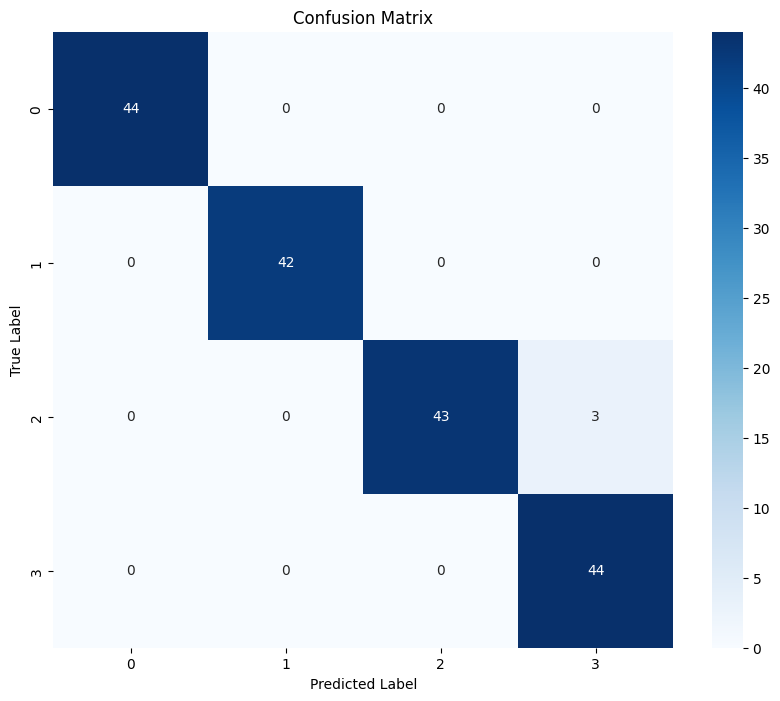


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        42
           2       1.00      0.93      0.97        46
           3       0.94      1.00      0.97        44

    accuracy                           0.98       176
   macro avg       0.98      0.98      0.98       176
weighted avg       0.98      0.98      0.98       176


Fold 2/5
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Batch 0/22, Time: 0.022s, Loss: 1.4405
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 25

C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\3359769142.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


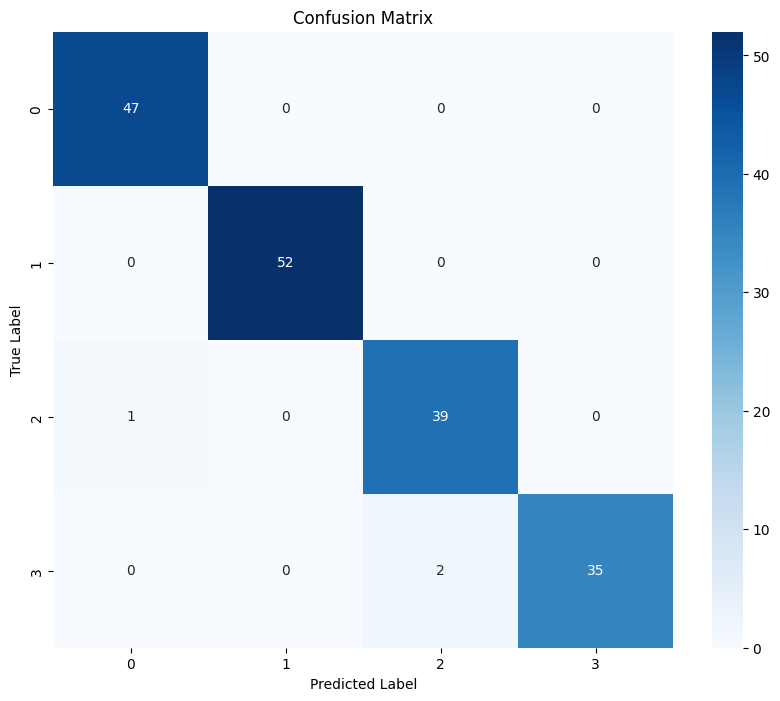


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      1.00      1.00        52
           2       0.95      0.97      0.96        40
           3       1.00      0.95      0.97        37

    accuracy                           0.98       176
   macro avg       0.98      0.98      0.98       176
weighted avg       0.98      0.98      0.98       176


Fold 3/5
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Batch 0/22, Time: 0.021s, Loss: 1.3956
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 25

C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\3359769142.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([16, 40])
Input Face shape: torch.Size([16, 768])
After projection - EEG shape: torch.Size([16, 256])
After projection - Face shape: torch.Size([16, 256])
Test Accuracy: 97.16%


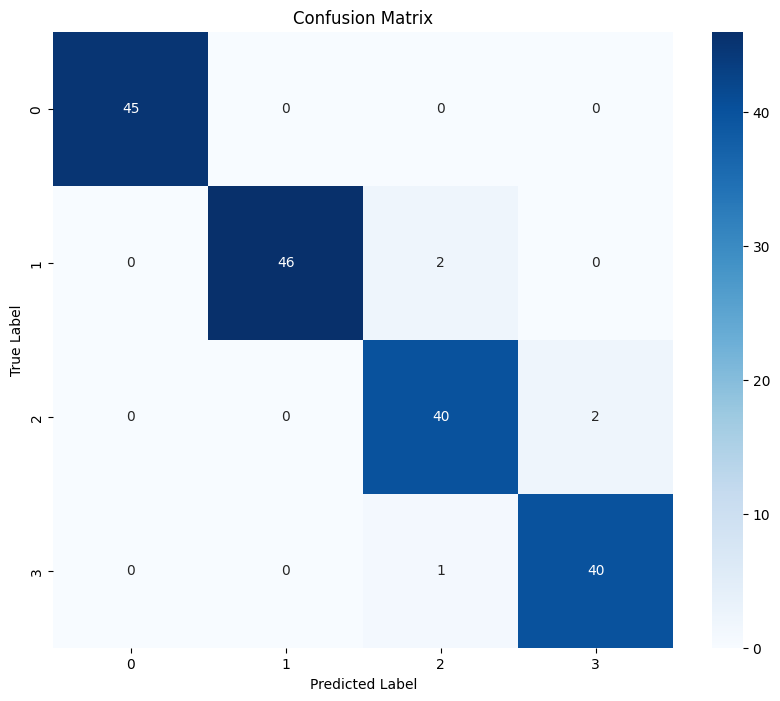


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      0.96      0.98        48
           2       0.93      0.95      0.94        42
           3       0.95      0.98      0.96        41

    accuracy                           0.97       176
   macro avg       0.97      0.97      0.97       176
weighted avg       0.97      0.97      0.97       176


Fold 4/5
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Batch 0/22, Time: 0.017s, Loss: 1.4451
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 25

C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\3359769142.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


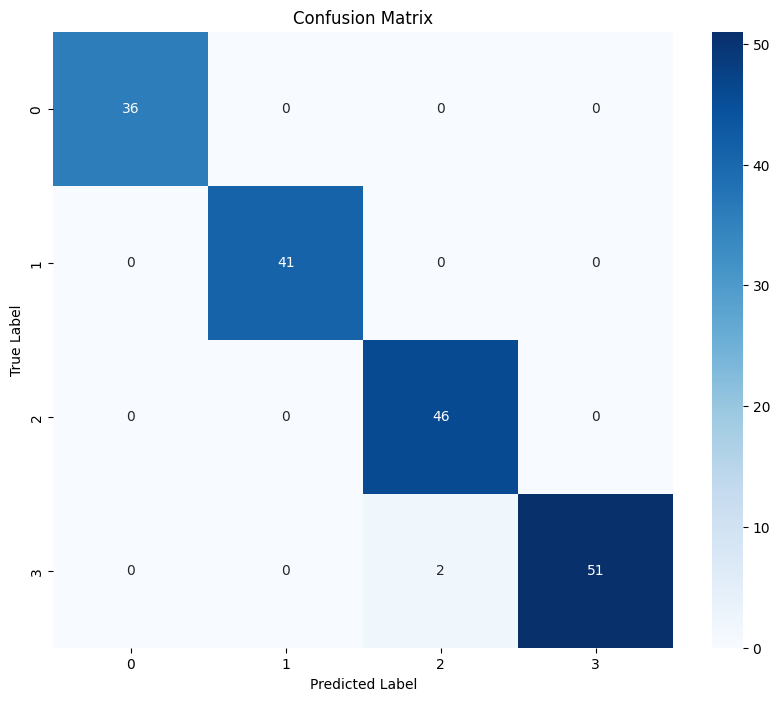


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        41
           2       0.96      1.00      0.98        46
           3       1.00      0.96      0.98        53

    accuracy                           0.99       176
   macro avg       0.99      0.99      0.99       176
weighted avg       0.99      0.99      0.99       176


Fold 5/5
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Batch 0/22, Time: 0.017s, Loss: 1.4023
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 25

C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\3359769142.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


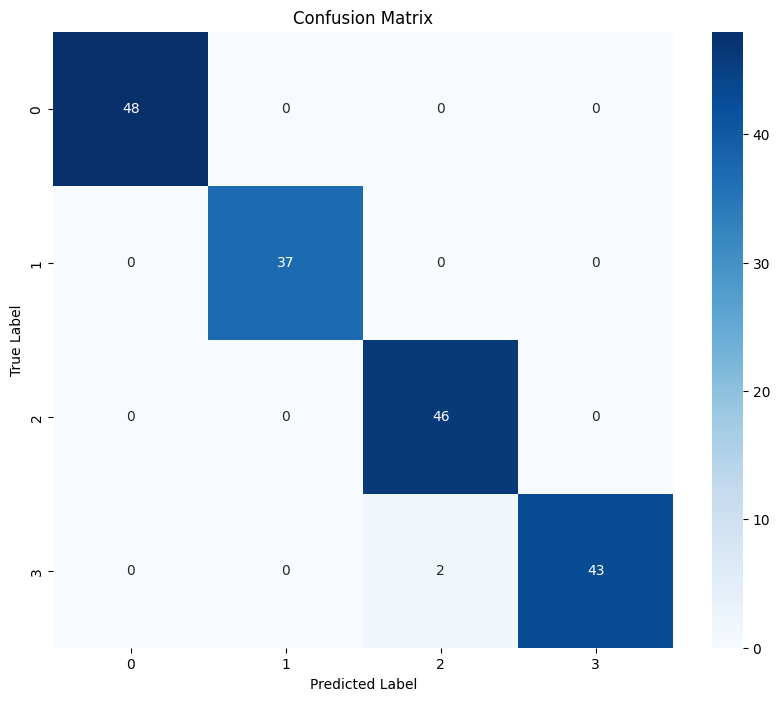


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        37
           2       0.96      1.00      0.98        46
           3       1.00      0.96      0.98        45

    accuracy                           0.99       176
   macro avg       0.99      0.99      0.99       176
weighted avg       0.99      0.99      0.99       176


Checking model robustness...
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])


C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\150745282.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Subset
import random

def set_seed(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def k_fold_cross_validation(model_class, dataset, k_folds=5, num_epochs=10, batch_size=32):
    """Perform k-fold cross validation"""
    set_seed()
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_results = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Create data loaders for this fold
        train_subsampler = Subset(dataset, train_ids)
        val_subsampler = Subset(dataset, val_ids)
        
        train_loader = torch.utils.data.DataLoader(
            train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(
            val_subsampler, batch_size=batch_size, shuffle=False)
        
        # Initialize a new model for each fold
        model = model_class(eeg_dim=40, face_dim=768)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        # Train and evaluate
        model = train_model(model, train_loader, val_loader, num_epochs=num_epochs)
        accuracy, predictions, true_labels = test_model(model, val_loader)
        fold_results.append({
            'accuracy': accuracy,
            'predictions': predictions,
            'true_labels': true_labels
        })
        
    return fold_results

def perform_robustness_checks(model, test_loader, noise_levels=[0.01, 0.05, 0.1]):
    """Test model robustness to noise"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    results = {}
    
    for noise in noise_levels:
        correct = 0
        total = 0
        with torch.no_grad():
            for eeg, face, labels in test_loader:
                eeg, face = eeg.to(device), face.to(device)
                labels = labels.to(device)
                
                # Add Gaussian noise
                eeg_noisy = eeg + torch.randn_like(eeg) * noise
                face_noisy = face + torch.randn_like(face) * noise
                
                outputs = model(eeg_noisy, face_noisy)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        results[noise] = accuracy
    
    return results

def analyze_feature_importance(model, test_loader):
    """Analyze feature importance using ablation study"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Baseline accuracy
    baseline_acc = test_model(model, test_loader)[0]
    
    # Test with zeroed EEG features
    def test_with_zeroed_features(zero_eeg=False, zero_face=False):
        correct = 0
        total = 0
        with torch.no_grad():
            for eeg, face, labels in test_loader:
                eeg, face = eeg.to(device), face.to(device)
                labels = labels.to(device)
                
                if zero_eeg:
                    eeg = torch.zeros_like(eeg)
                if zero_face:
                    face = torch.zeros_like(face)
                
                outputs = model(eeg, face)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return 100 * correct / total
    
    eeg_zeroed_acc = test_with_zeroed_features(zero_eeg=True)
    face_zeroed_acc = test_with_zeroed_features(zero_face=True)
    
    return {
        'baseline': baseline_acc,
        'eeg_zeroed': eeg_zeroed_acc,
        'face_zeroed': face_zeroed_acc
    }

def plot_validation_results(fold_results, robustness_results, importance_results):
    """Plot comprehensive validation results"""
    plt.figure(figsize=(15, 10))
    
    # Plot 1: K-fold accuracies
    plt.subplot(2, 2, 1)
    accuracies = [res['accuracy'] for res in fold_results]
    plt.boxplot(accuracies)
    plt.title('K-fold Cross Validation Accuracies')
    plt.ylabel('Accuracy (%)')
    
    # Plot 2: Robustness to noise
    plt.subplot(2, 2, 2)
    noise_levels = list(robustness_results.keys())
    accuracies = list(robustness_results.values())
    plt.plot(noise_levels, accuracies, marker='o')
    plt.title('Model Robustness to Noise')
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy (%)')
    
    # Plot 3: Feature importance
    plt.subplot(2, 2, 3)
    importances = [importance_results['baseline'], 
                  importance_results['eeg_zeroed'],
                  importance_results['face_zeroed']]
    plt.bar(['Baseline', 'No EEG', 'No Face'], importances)
    plt.title('Feature Importance Analysis')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

# Run comprehensive validation
def run_comprehensive_validation(model_class, dataset, test_loader):
    print("Starting comprehensive validation...")
    
    # 1. K-fold Cross Validation
    print("\nPerforming k-fold cross validation...")
    fold_results = k_fold_cross_validation(model_class, dataset)
    
    # 2. Load best model
    model = model_class(eeg_dim=40, face_dim=768)
    model, _ = load_best_model(model)
    
    # 3. Robustness Check
    print("\nChecking model robustness...")
    robustness_results = perform_robustness_checks(model, test_loader)
    
    # 4. Feature Importance Analysis
    print("\nAnalyzing feature importance...")
    importance_results = analyze_feature_importance(model, test_loader)
    
    # 5. Plot Results
    plot_validation_results(fold_results, robustness_results, importance_results)
    
    # Print summary statistics
    print("\nValidation Summary:")
    print(f"Average K-fold Accuracy: {np.mean([r['accuracy'] for r in fold_results]):.2f}%")
    print(f"Std Dev of K-fold Accuracy: {np.std([r['accuracy'] for r in fold_results]):.2f}%")
    print("\nRobustness Results:")
    for noise, acc in robustness_results.items():
        print(f"Noise level {noise}: {acc:.2f}% accuracy")
    print("\nFeature Importance:")
    for feature, acc in importance_results.items():
        print(f"{feature}: {acc:.2f}% accuracy")

# Usage
model_class = EEGFaceTransformer
run_comprehensive_validation(model_class, dataset, test_loader)

C:\Users\tahir\AppData\Local\Temp\ipykernel_1052\3359769142.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([32, 40])
Input Face shape: torch.Size([32, 768])
After projection - EEG shape: torch.Size([32, 256])
After projection - Face shape: torch.Size([32, 256])
Input EEG shape: torch.Size([24, 40])
Input Face shape: torch.Size([24, 768])
After projection - EEG shape: torch.Size([24, 256])
After projection - Face shape: torch.Size([24, 256])
Test Accuracy: 100.00%


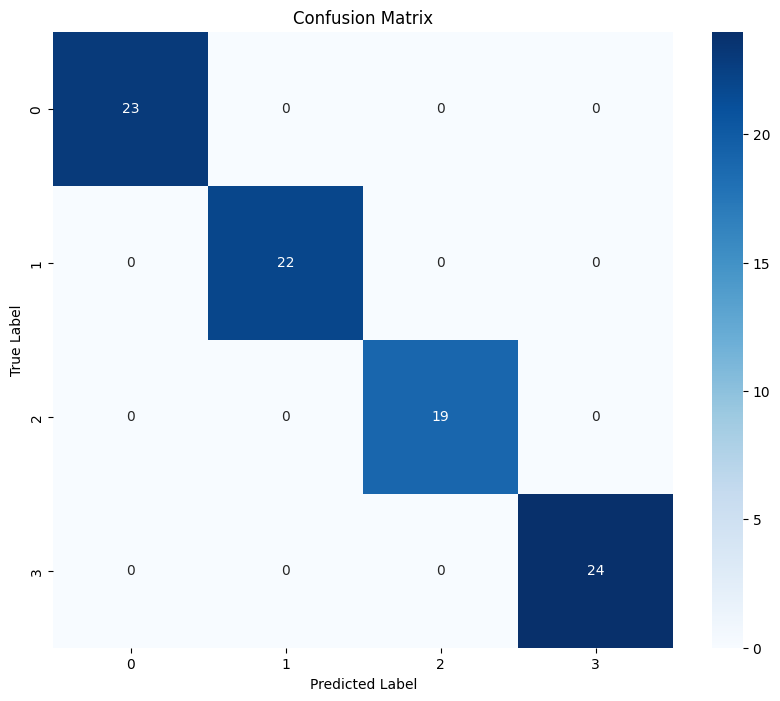


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        24

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



In [ ]:
def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the best model
    checkpoint = torch.load('checkpoints/best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for eeg, face, labels in test_loader:
            eeg, face = eeg.to(device), face.to(device)
            labels = labels.to(device)
            
            # Get predictions
            outputs = model(eeg, face)
            _, predicted = torch.max(outputs.data, 1)
            
            # Calculate accuracy
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Store predictions and labels for additional metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * test_correct / test_total
    
    # Print results
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Calculate and print confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    return accuracy, all_preds, all_labels

# Use the test function
model = EEGFaceTransformer(eeg_dim=40, face_dim=768)
accuracy, predictions, true_labels = test_model(model, test_loader)